In [1]:
from datasets import load_dataset
from tensorflow import keras
import time
import json
import pandas as pd
import glob
import pdb
import numpy as np
import tensorflow as tf
import os
from unet_utils import *
import matplotlib.pyplot as plt
from pathlib import Path
import math

### Training without weighted loss

In [2]:
unet = padding_model(start_neurons=32, activation='relu', dropout=False) 
params={
    'start_neurons'   :32,      # Controls size of hidden layers in CNN, higher = more complexity 
    'activation'      :'relu',  # Activation used throughout the U-Net,  see https://www.tensorflow.org/api_docs/python/tf/keras/activations
    'loss'            :'mae',   # Either 'mae' or 'mse', or others as https://www.tensorflow.org/api_docs/python/tf/keras/losses
    'loss_weights'    : 1,    # Scale for loss.  Recommend squaring this if using MSE
    'opt'             :tf.keras.optimizers.Adam,  # optimizer, see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
    'learning_rate'   :0.05718,   # Learning rate for optimizer
    'num_epochs'      :200,       # Number of epochs to train for
    'batch'           :53
}
opt=params['opt'](learning_rate=params['learning_rate'], amsgrad=False)
unet.compile(optimizer=opt, loss=params['loss'], loss_weights=[params['loss_weights']], metrics=[tf.keras.metrics.MeanAbsoluteError()])

############# data ###############
X_data = np.load('input_data.npy')
X_data = np.expand_dims(X_data, axis=-1)
Y_data = np.load('target_data.npy')
Y_data = np.expand_dims(Y_data, axis=-1)

tensorslice = tf.data.Dataset.from_tensor_slices((X_data,Y_data)).shuffle(buffer_size=len(Y_data),reshuffle_each_iteration=False).batch(params['batch'])
train_data = tensorslice.skip(int(len(tensorslice) * 0.25)).shuffle(buffer_size=len(Y_data),reshuffle_each_iteration=True)
test_data = tensorslice.take(int(len(tensorslice) * 0.25)).shuffle(buffer_size=len(Y_data),reshuffle_each_iteration=True)
##################################

training_dir = 'training_dir'
testcase = 'tuned_unet'
# Path(f'{training_dir}/tensorboard/{testcase}').mkdir(parents=True, exist_ok=True)

callbacks=[
    tf.keras.callbacks.ModelCheckpoint(training_dir+f'/{testcase}.hdf5', 
                    monitor='val_loss',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=f'{training_dir}/tensorboard/{testcase}'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.2)
]

history1 = unet.fit(train_data, validation_data=test_data,
                  epochs=params['num_epochs'],
                  callbacks=callbacks,
                  workers=8)

2022-03-02 11:20:14.785589: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-02 11:20:18.792776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30998 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0
2022-03-02 11:20:19.734589: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-02 11:20:19.734633: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-02 11:20:19.734687: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-03-02 11:20:19.740771: W tensorflow/stream_execu

Epoch 1/200


2022-03-02 11:20:21.024137: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-02 11:20:24.666768: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


  3/199 [..............................] - ETA: 19s - loss: 1.5577 - mean_absolute_error: 1.5577

2022-03-02 11:20:37.838471: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-02 11:20:37.838522: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-02 11:20:37.838603: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2022-03-02 11:20:37.860599: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-02 11:20:37.860704: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-03-02 11:20:37.870033: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-02 11:20:37.872511: I tensorflow

199/199 [==============================] - 21s 18ms/step - loss: 0.0925 - mean_absolute_error: 0.0925 - val_loss: 0.0795 - val_mean_absolute_error: 0.0795
Epoch 2/200
199/199 [==============================] - 3s 14ms/step - loss: 0.0388 - mean_absolute_error: 0.0388 - val_loss: 0.0392 - val_mean_absolute_error: 0.0392
Epoch 3/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0353 - mean_absolute_error: 0.0353 - val_loss: 0.0389 - val_mean_absolute_error: 0.0389
Epoch 4/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0343 - mean_absolute_error: 0.0343 - val_loss: 0.0310 - val_mean_absolute_error: 0.0310
Epoch 5/200
199/199 [==============================] - 3s 14ms/step - loss: 0.0304 - mean_absolute_error: 0.0304 - val_loss: 0.0726 - val_mean_absolute_error: 0.0726
Epoch 6/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0279 - mean_absolute_error: 0.0279 - val_loss: 0.0486 - val_mean_absolute_error: 0.0486
Epoch 7/200
199

199/199 [==============================] - 3s 16ms/step - loss: 0.0158 - mean_absolute_error: 0.0158 - val_loss: 0.0169 - val_mean_absolute_error: 0.0169
Epoch 51/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165
Epoch 52/200
199/199 [==============================] - 3s 14ms/step - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165
Epoch 53/200
199/199 [==============================] - 3s 14ms/step - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165
Epoch 54/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0153 - mean_absolute_error: 0.0153 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 55/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0152 - mean_absolute_error: 0.0152 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165
Epoch 56/20

199/199 [==============================] - 3s 15ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 100/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 101/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 102/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 103/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0163 - val_mean_absolute_error: 0.0163
Epoch 104/200
199/199 [==============================] - 3s 14ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 

Epoch 148/200
199/199 [==============================] - 3s 13ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0163 - val_mean_absolute_error: 0.0163
Epoch 149/200
199/199 [==============================] - 3s 12ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 150/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 151/200
199/199 [==============================] - 3s 16ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 152/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 153/200
199/199 [==============================] - 3s 15ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error:

Epoch 197/200
199/199 [==============================] - 3s 12ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0163 - val_mean_absolute_error: 0.0163
Epoch 198/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 199/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164
Epoch 200/200
199/199 [==============================] - 3s 13ms/step - loss: 0.0149 - mean_absolute_error: 0.0149 - val_loss: 0.0164 - val_mean_absolute_error: 0.0164


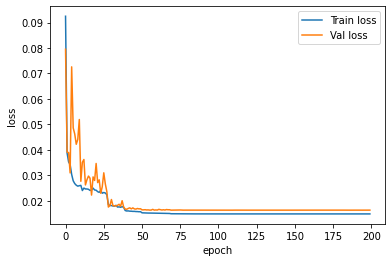

In [4]:
plt.plot(history1.history['loss'],label='Train loss')
plt.plot(history1.history['val_loss'],label='Val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()